### Computational Challenge 4

Group 3: Manoj, Rashed, Daniel, Zhao

Consider the deterministic repressilator described via the Michaelis-Menten equations in Loinger, et al

• Construct a Petri net representation of the system for case 
    (i) with mRNA (i.e. corre-sponding to Eq. 1)  
    (ii) without mRNA (i.e. corresponding to Eq.2)
    
• Solve the ODEs for case (i) numerically with parameters:
    k=dm= 1 and dp=gp.
    
• Plot phase portraits showing the region in which the system displays oscillations, with values of gp on the x-axis plotted against values of gm on the y-axis, for Hill coefficients n= [1,2,3] 

• Repeat the same exercise for case (ii)

## Background (Longier&Biham2007 ; Elowitz2000)


### The genetic repressilator circuit consists of three transcription factors, or repressors, which negatively regulate each other in a cyclic manner. 

### This circuit was synthetically constructed on plasmids in Escherichia coli and was found to exhibit oscillations in the concentrations of the three repressors. 

### Background (Longier&Biham2007 ; Elowitz2000)

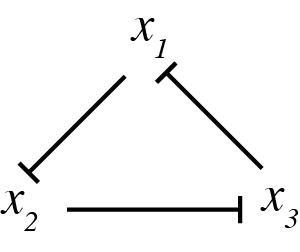


### Represillator Circuit as a Synthetic Biological Clock
 
A ____|  B      high  | low   |  high  |  low   |  high  |  low   |   high
      |               |       |        |        |        |        |
      
      
      ------------------------------------------------------------------------
 
 
B ____|  C     high   | high  |  low   |  high  |  low   |  high  |   low
      |               |       |        |        |        |        |
      
      
      -----------1-------2--------3--------4--------5--------6---------7--
      
C ____|  A      high  | low   |  high  |  low   |  high  |  low   |   high
      |               |       |        |        |        |        |
      
 
Summarily ____   C   -->  B  -->   A -->    C   occurs at certain conditions
                     

## Background (Longier&Biham2007 ; Elowitz2000)

### The repressilator is found to oscillate with period t ~ 150 mins

### The oscillations are noisy and irregular. 

### Recent theoretical work has shown that stochastic effects maybe responsible for noisy operation in natural gene-expression networks [2]

### The role of fluctuations is enhanced due to the discrete nature of the transcription factors and their binding sites, which may appear in low copy numbers [1]

### Therefore, the repressilator circuit cannot be fully analyzed using deterministic methods such as rate equations. Here we perform stochastic analysis of the repressilator circuit using the master equation and Monte Carlo simulations.

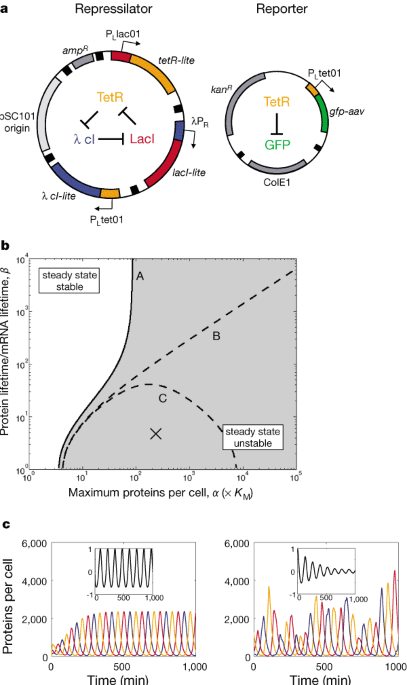

### Question 1:

### Construct a Petri net representation of the system for case (i) with mRNA (i.e. corre-sponding to Eq. 1)
(ii) without mRNA (i.e. corresponding to Eq.2)

In [1]:
# We use these to constuct the Petrinet representation of the system
import snakes.plugins
snakes.plugins.load('gv', 'snakes.nets', 'nets')
from nets import *

# We will use these to solve the odes we develop
import scipy, scipy.integrate, scipy.optimize, pylab, copy
import numpy as np

# We will use Matplotlib to make a 3D plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap
from matplotlib.colors import PowerNorm

# We will make use of sliders
import panel as pn
pn.extension()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Creating an empty PetriNet

n = PetriNet("repressilator")

# creating places with arbitrary tokens

n.add_place(Place('src',[1e8]))
n.add_place(Place('x1', [3]))
n.add_place(Place('x2', [4]))
n.add_place(Place('x3', [5]))
n.add_place(Place('m1', [300]))
n.add_place(Place('m2', [400]))
n.add_place(Place('m3', [500]))
n.add_place(Place('sink', [0]))

# create reactions

# rxns involving the proteins
n.add_transition(Transition('t2', Expression('x1_prod') ))
n.add_transition(Transition('t6', Expression('x2_prod') ))
n.add_transition(Transition('t10', Expression('x3_prod') ))
n.add_transition(Transition('t3', Expression('x1_deg') ))
n.add_transition(Transition('t7', Expression('x2_deg') ))
n.add_transition(Transition('t11', Expression('x3_deg') ))

# rxns involving mRNAs
n.add_transition(Transition('t1', Expression('m1_prod') ))
n.add_transition(Transition('t5', Expression('m2_prod') ))
n.add_transition(Transition('t9', Expression('m3_prod') ))
n.add_transition(Transition('t4', Expression('m1_deg') ))
n.add_transition(Transition('t8', Expression('m2_deg') ))
n.add_transition(Transition('t12', Expression('m3_deg') ))

# add arcs to link up transitions

n.add_input('x1', 't3', Value(1))
n.add_output('sink', 't3', Value(1))
n.add_output('x1', 't2', Value(1))

n.add_output('x2', 't6', Value(1))
n.add_input('x2', 't7', Value(1))
n.add_output('sink', 't7', Value(1))

n.add_output('x3', 't10', Value(1))
n.add_input('x3', 't11', Value(1))
n.add_output('sink', 't11', Value(1))

n.add_input('m1', 't2', Value(1))
n.add_output('m1', 't2', Value(1))
n.add_input('x1', 't5', Value(1))
n.add_input('x3', 't1', Value(1))
n.add_input('src', 't1', Value(1))
n.add_output('m1', 't1', Value(1))
n.add_input('m1', 't4', Value(1))
n.add_output('sink', 't4', Value(1))
n.add_output('sink', 't8', Value(1))
n.add_input('src', 't5', Value(1))
n.add_output('m2', 't5', Value(1))
n.add_input('m2', 't8', Value(1))
n.add_output('sink', 't12', Value(1))
n.add_input('src', 't9', Value(1))
n.add_input('x2', 't9', Value(1))
n.add_output('m3', 't9', Value(1))
n.add_input('m3', 't12', Value(1))
n.add_input('m3', 't10', Value(1))
n.add_output('m3', 't10', Value(1))
n.add_input('m2', 't6', Value(1))
n.add_output('m2', 't6', Value(1))

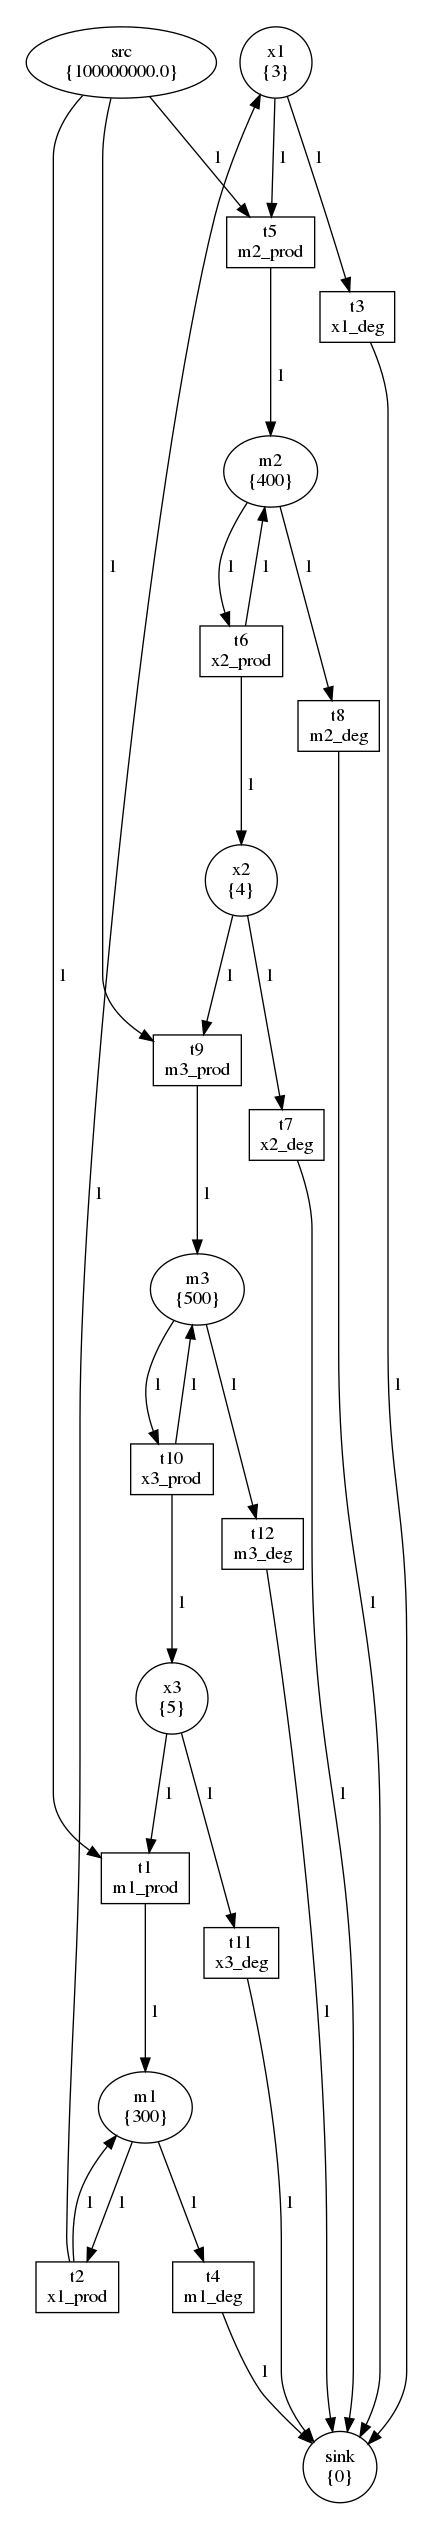

In [3]:
n.draw("repressilator.png")

#display image
from IPython.display import Image
Image(filename='repressilator.png') 

## Question 2:
    
### Solve the ODEs for case (i) numerically with parameters: k=dm= 1 and dp=gp.


In [72]:
# <codecell>
class HillRepressilator:
    def __init__(self, gamma_m, gamma_p, del_m, del_p, n, k, y0):
        """
        Initiate a HillRepressilator (i.e., a Repressilator where the
        protein-DNA interaction is subsumed in a simple Hill function).
        Instance parameters are initialized based on the input parameters
        Also store the bare parameters (K_m, K_p, T, K_b) so that you can
        convert from scaled times and concentrations back to bare times
        and concentrations if desired.
        """
        self.gamma_m = 10**gamma_m
        self.gamma_p = 10**gamma_p
        self.del_m=del_m
        self.del_p=10**del_p
        self.n = n
        self.k = k
        self.y0_6 = y0



    @staticmethod
    def dydt(y, t, log_gm, log_gp, del_m, log_dp, n, k):
        """Define the right-hand-side of the Repressilator equations
        for use with scipy.integrate.odeint.  Since this needs to be called
        as if it were a standalone function, and not an instance method
        (which would implicitly assume the first argument is the instance
        self), we declare this as a staticmethod so that self is not passed
        as an implicit argument.  Alternatively, one could define dydt
        outside the HillRepressilator class, but this is cleaner."""
        
        """
    Returns 6-array of (dm_1/dt, dm_2/dt, dm_3/dt, dx_1/dt, dx_2/dt, dx_3/dt)
    """
        m_1, m_2, m_3, x_1, x_2, x_3 = y
        
        gamma_m = 10**log_gm
        gamma_p = 10**log_gp
        del_p=10**log_dp
    
        return np.array(
            [
                gamma_m/(1+(k*(x_3**n))) - del_m*m_1,
                gamma_m/(1+(k*(x_1**n))) - del_m*m_2,
                gamma_m/(1+(k*(x_2**n))) - del_m*m_3,
                gamma_p *m_1 - del_p*x_1,
                gamma_p *m_2 - del_p*x_2,
                gamma_p *m_3 - del_p*x_3
            ]
        )
        
        
    def run(self, y0, T, nT, params):
        """
        run(self, )
        Run the Repressilator for the specified amount of time T, returning
        output for a specified array of times.  Store the trajectory returned
        by odeint in the instance variable self.traj, concatenating the result
        to the existing self.traj if a previous trajectory had been created.
        """
        self.args = params
        self.time = np.linspace(0, T, nT)
        self.x = scipy.integrate.odeint(self.dydt, self.y0_6, self.time, self.args)
        m1, m2, m3, x1, x2, x3 = self.x.transpose()
        self.traj = self.x.transpose()
        
        return [self.time, self.traj]
        
        
    def find_steady_state(self,alpha=None, n=None, alpha0=None):
        """Return the steady-state concentration of mRNAs and proteins
        (i.e., an array of length 6) for the specified parameters
        alpha, n, alpha0.  Use scipy.optimize.fsolve."""
        pass
    

    def plot(self, time, soln, show_proteins, show_mRNAs):
        """Plot the trajectory of the Repressilator, optionally showing
        either the protein concentrations or the mRNA concentrations,
        in either dimensionless or rescaled units."""
        
        number = 6
        cmap = plt.get_cmap('gnuplot')
        colors = [cmap(i) for i in np.linspace(0, 1, number)]
    
        
        m1, m2, m3, x1, x2, x3 = soln
        
        
        if show_proteins:
            plt.plot(time, x1, LineWidth=2, color=colors[0], label="x1")
            plt.plot(time, x2, LineWidth=2, color=colors[2], label="x2")
            plt.plot(time, x3, LineWidth=2, color=colors[4], label="x3")
            plt.legend(loc='best')
            plt.show()
            
        if show_mRNAs:
            plt.plot(time, m1, LineWidth=2, color=colors[1], label="m1")
            plt.plot(time, m2, LineWidth=2, color=colors[3], label="m2")
            plt.plot(time, m3, LineWidth=2, color=colors[5], label="m3")
            plt.legend(loc='best')
            plt.show()
            

    def plot_phase_diagram(self, var1, var2, varName1, varName2):
        # Solve for species concentrations    
        
        self.var1 = var1
        self.var2 = var2
        
        #p.circle(x_fp, x_fp, color="black", size=12)
        plt.plot(self.var1, self.var2, lineWidth=2)
        plt.ylabel(varName1)
        plt.xlabel(varName2)

        return plt
    

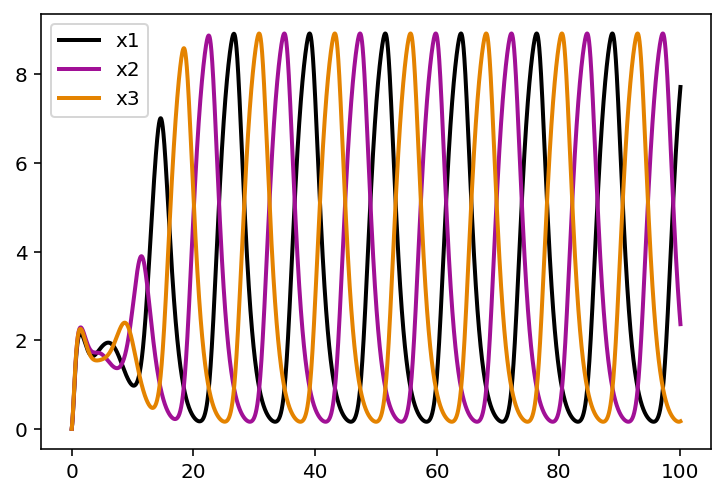

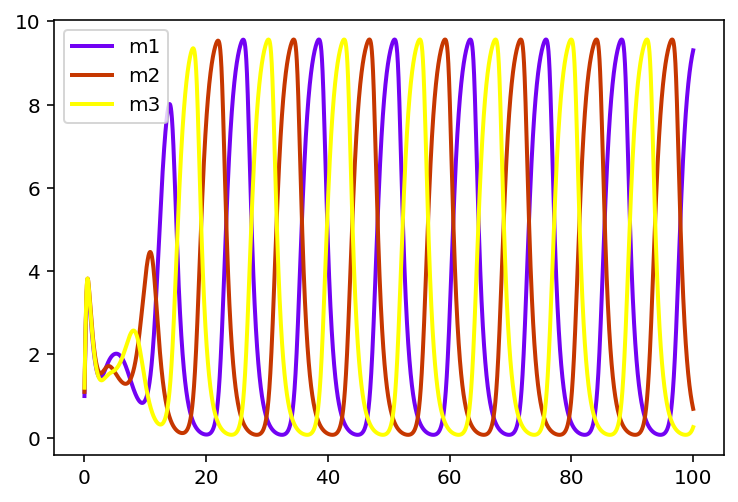

In [73]:
n=3.
k=1
d_m=1.

# protein production and decay rate set to 10**0 = 1
log_dp=0
log_gp=0

# mRNA production rate set to 10
log_gm=1      

# initialize species vector
y0=[1,1.1,1.2,0,0,0]

# initialize HillRepressilator object repsl with above ppts.
repls = HillRepressilator(log_gm, log_gp, d_m, log_dp, n, k, y0)

# Set parameters for running simulation unchanged and solve odes
params = (log_gm, log_gp, d_m, log_dp, n, k)
[tsolve, soln] = HillRepressilator.run(repls, y0, 100, 10000, params)

# Plot system dynamics
HillRepressilator.plot(repls, tsolve, soln, "True", "True")

## Question 3:
    
### Plot phase portraits showing the region in which the system displays oscillations, with values of gp on the x-axis plotted against values of gm on the y-axis, for Hill coefficients n= [1,2,3] 


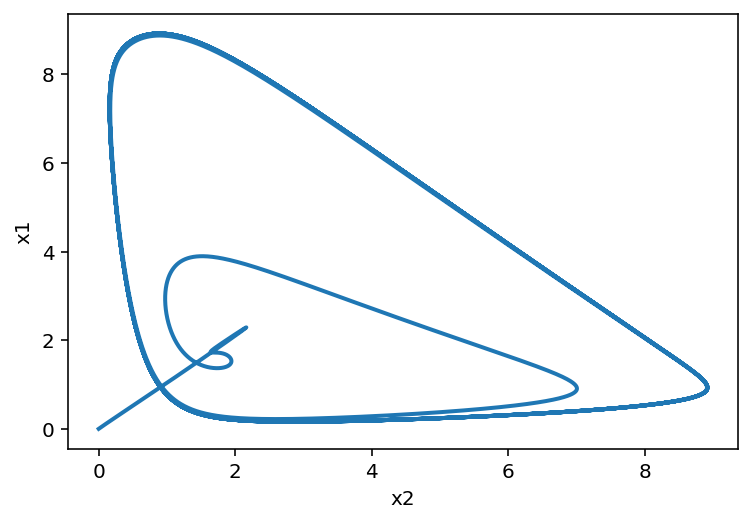

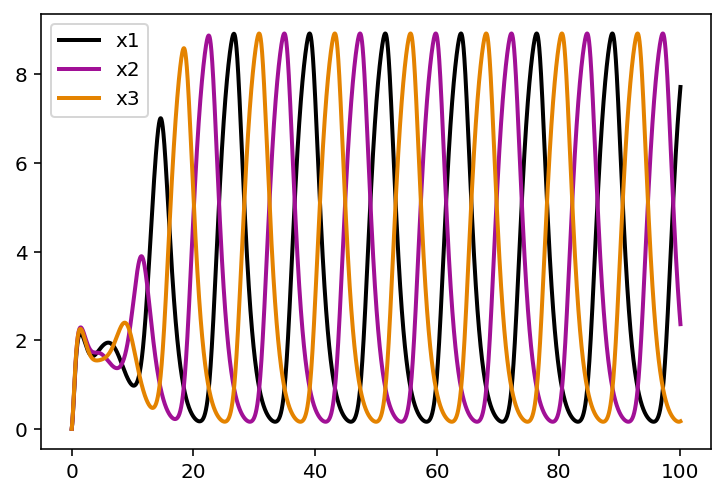

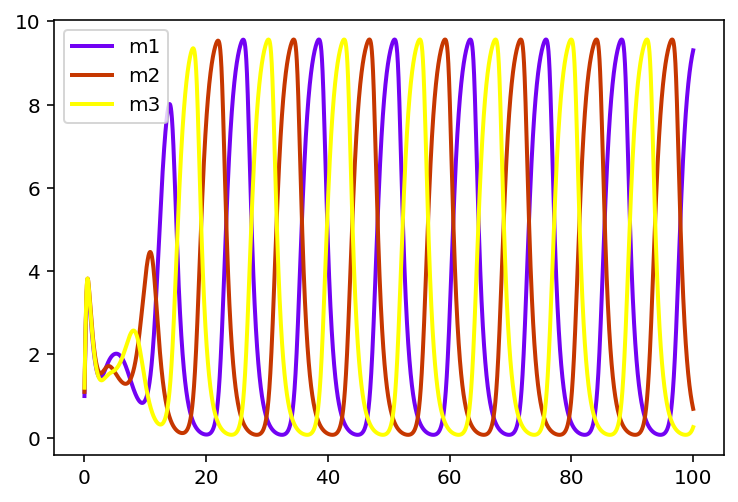

In [74]:
# plot phase potrait for x1 and x2 using initial parameters

m1, m2, m3, x1, x2, x3 = soln

# Plot phase portrait
plt.subplots(1)
HillRepressilator.plot_phase_diagram(repls, x1, x2, "x1", "x2")

plt.subplots(1)
# Plot system dynamics
HillRepressilator.plot(repls, tsolve, soln, "True", "True")

### Case n =1

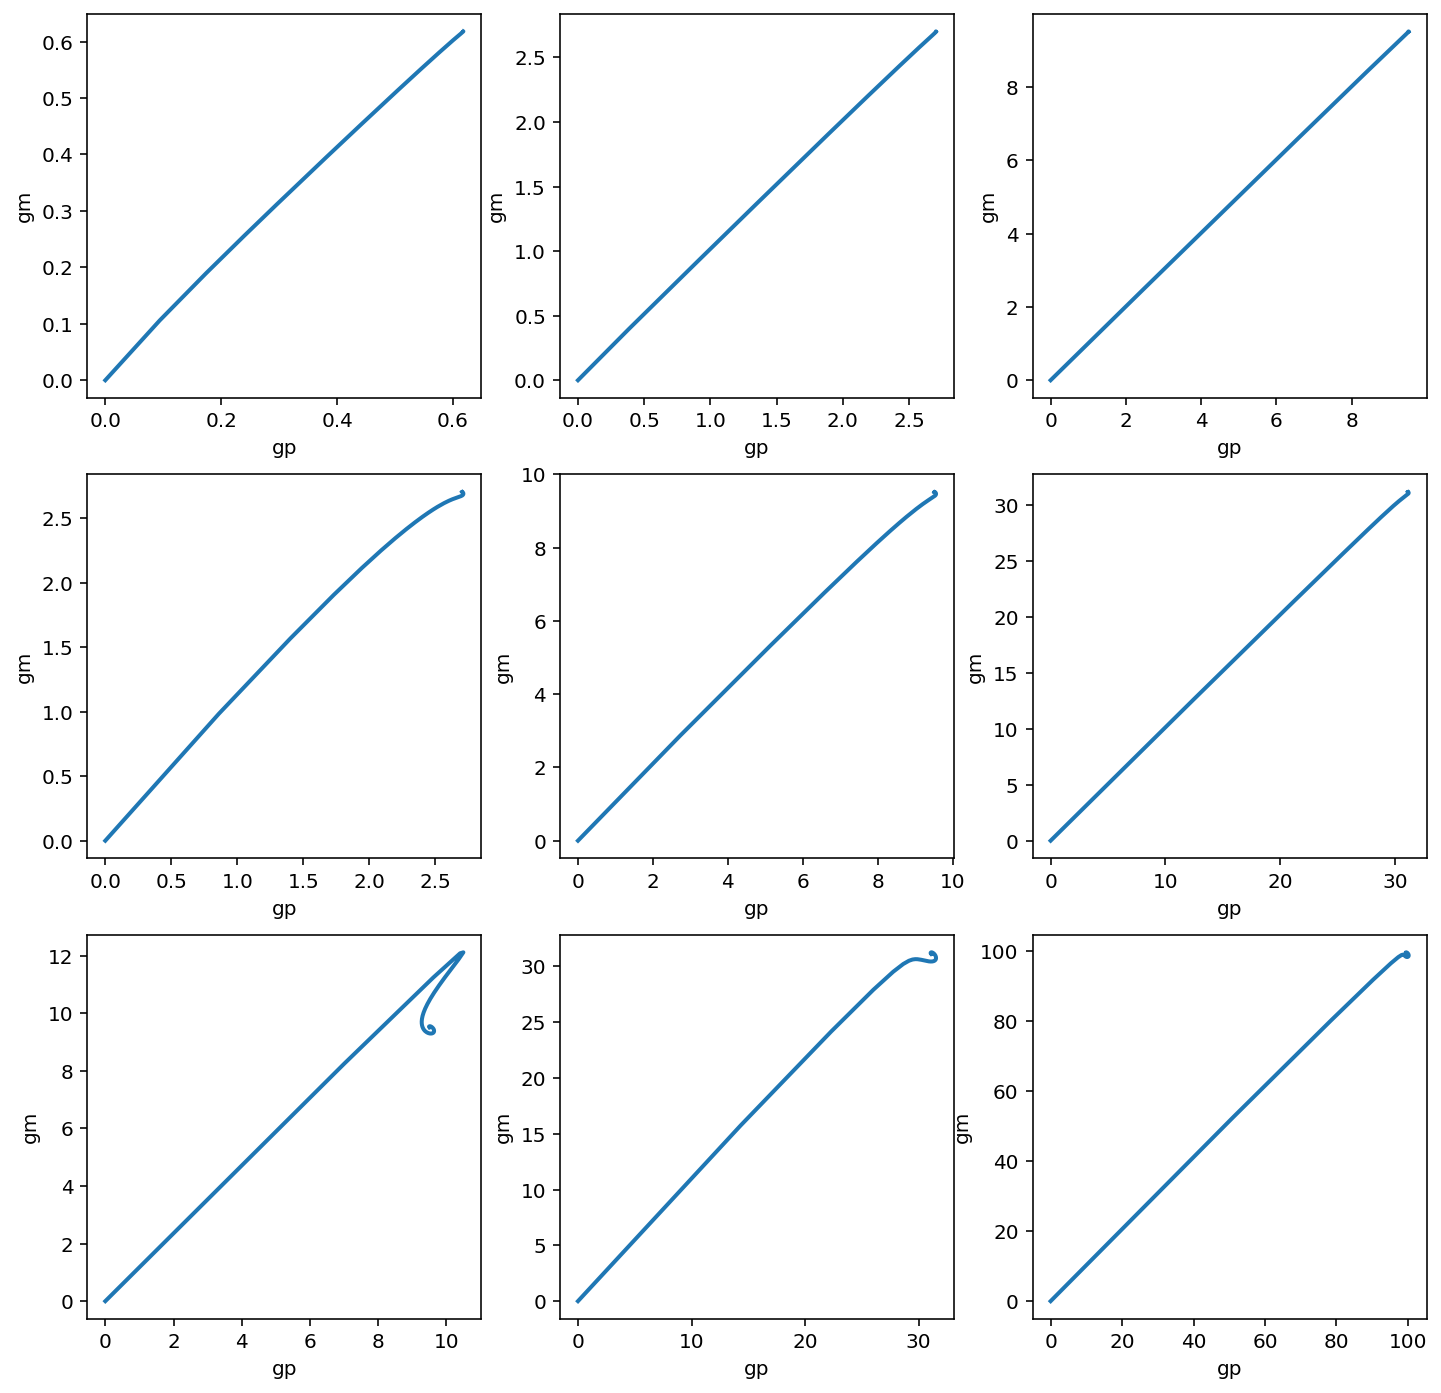

In [101]:
k=1
d_m=1.
y0=[1,1.1,1.2,0,0,0]

# protein production and decay rate
# ranging from -3 to 0
log_dp=1.
log_gp=1.

# mRNA production rate
# ranging from 0 to 3
log_gm=3     

repls1x1 = []
repls1x2 = []
repls1x3 = []
repls2x1 = []
repls2x2 = []
repls2x3 = []
repls3x1 = []
repls3x2 = []
repls3x3 = []

n = 1
for log_gp in range(0,3):
    for log_gm in range(1,4):
        repls = HillRepressilator(log_gm, log_gp, d_m, log_gp, n, k, y0)
        params = (log_gm, log_gp, d_m, log_dp, n, k)
        [tsolve, soln] = HillRepressilator.run(repls, y0, 100, 1000, params)
        m1, m2, m3, x1, x2, x3 = soln
        repls1x1.append(x1)
        repls1x3.append(x3)

n = 2
for log_gp in range(0,3):
    for log_gm in range(1,4):
        repls = HillRepressilator(log_gm, log_gp, d_m, log_gp, n, k, y0)
        params = (log_gm, log_gp, d_m, log_dp, n, k)
        [tsolve, soln] = HillRepressilator.run(repls, y0, 100, 1000, params)
        m1, m2, m3, x1, x2, x3 = soln
        repls2x1.append(x1)
        repls2x3.append(x3)
        
n = 3
for log_gp in range(0,3):
    for log_gm in range(1,4):
        repls = HillRepressilator(log_gm, log_gp, d_m, log_gp, n, k, y0)
        params = (log_gm, log_gp, d_m, log_dp, n, k)
        [tsolve, soln] = HillRepressilator.run(repls, y0, 100, 1000, params)
        m1, m2, m3, x1, x2, x3 = soln
        repls3x1.append(x1)
        repls3x3.append(x3)
        
import matplotlib.pylab as plb
        
        
plb.figure(figsize=(12,12))

for i in range(9):
    plb.subplot(3,3,i+1)
    HillRepressilator.plot_phase_diagram(repls, repls1x1[i], repls1x3[i],
                                         "gm", "gp")       


### Case n = 2

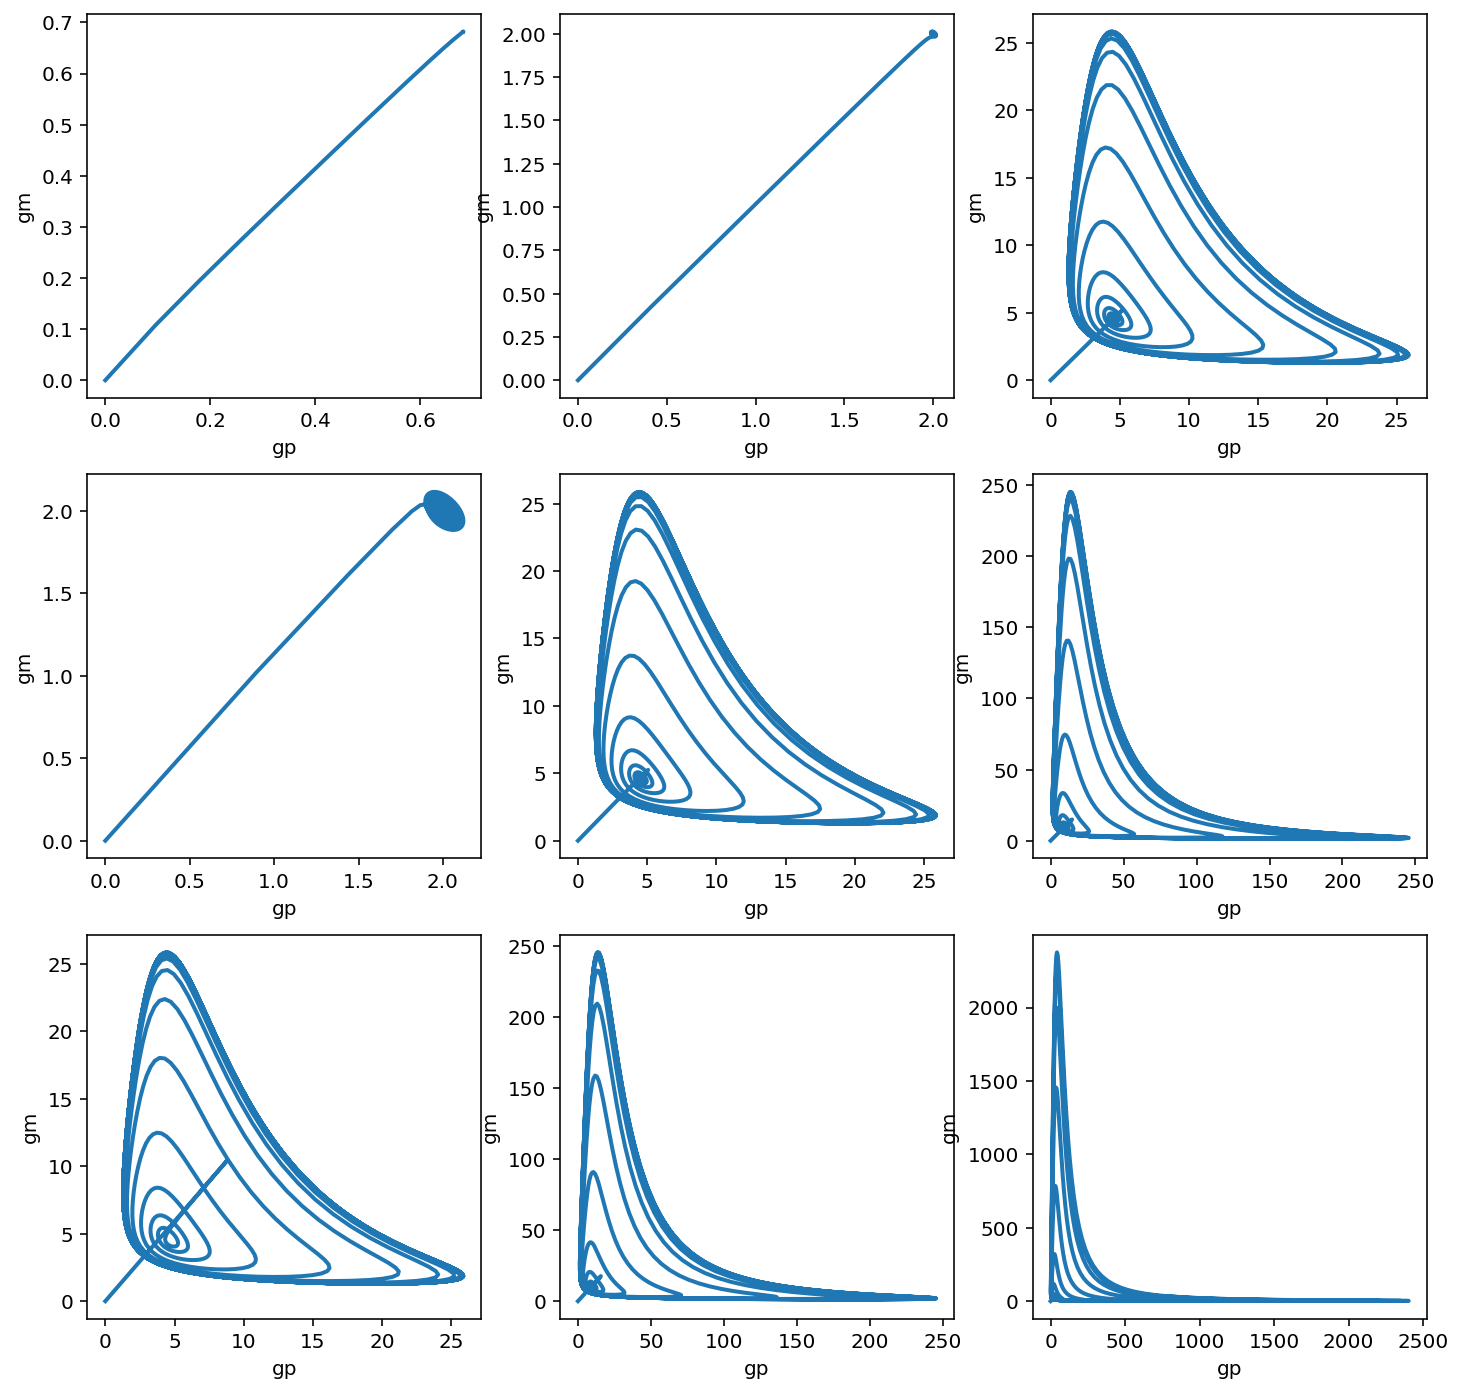

In [100]:
plb.figure(figsize=(12,12))

for i in range(9):
    plb.subplot(3,3,i+1)
    HillRepressilator.plot_phase_diagram(repls, repls2x1[i], repls2x3[i],
                                         "gm", "gp")

### Case n = 3

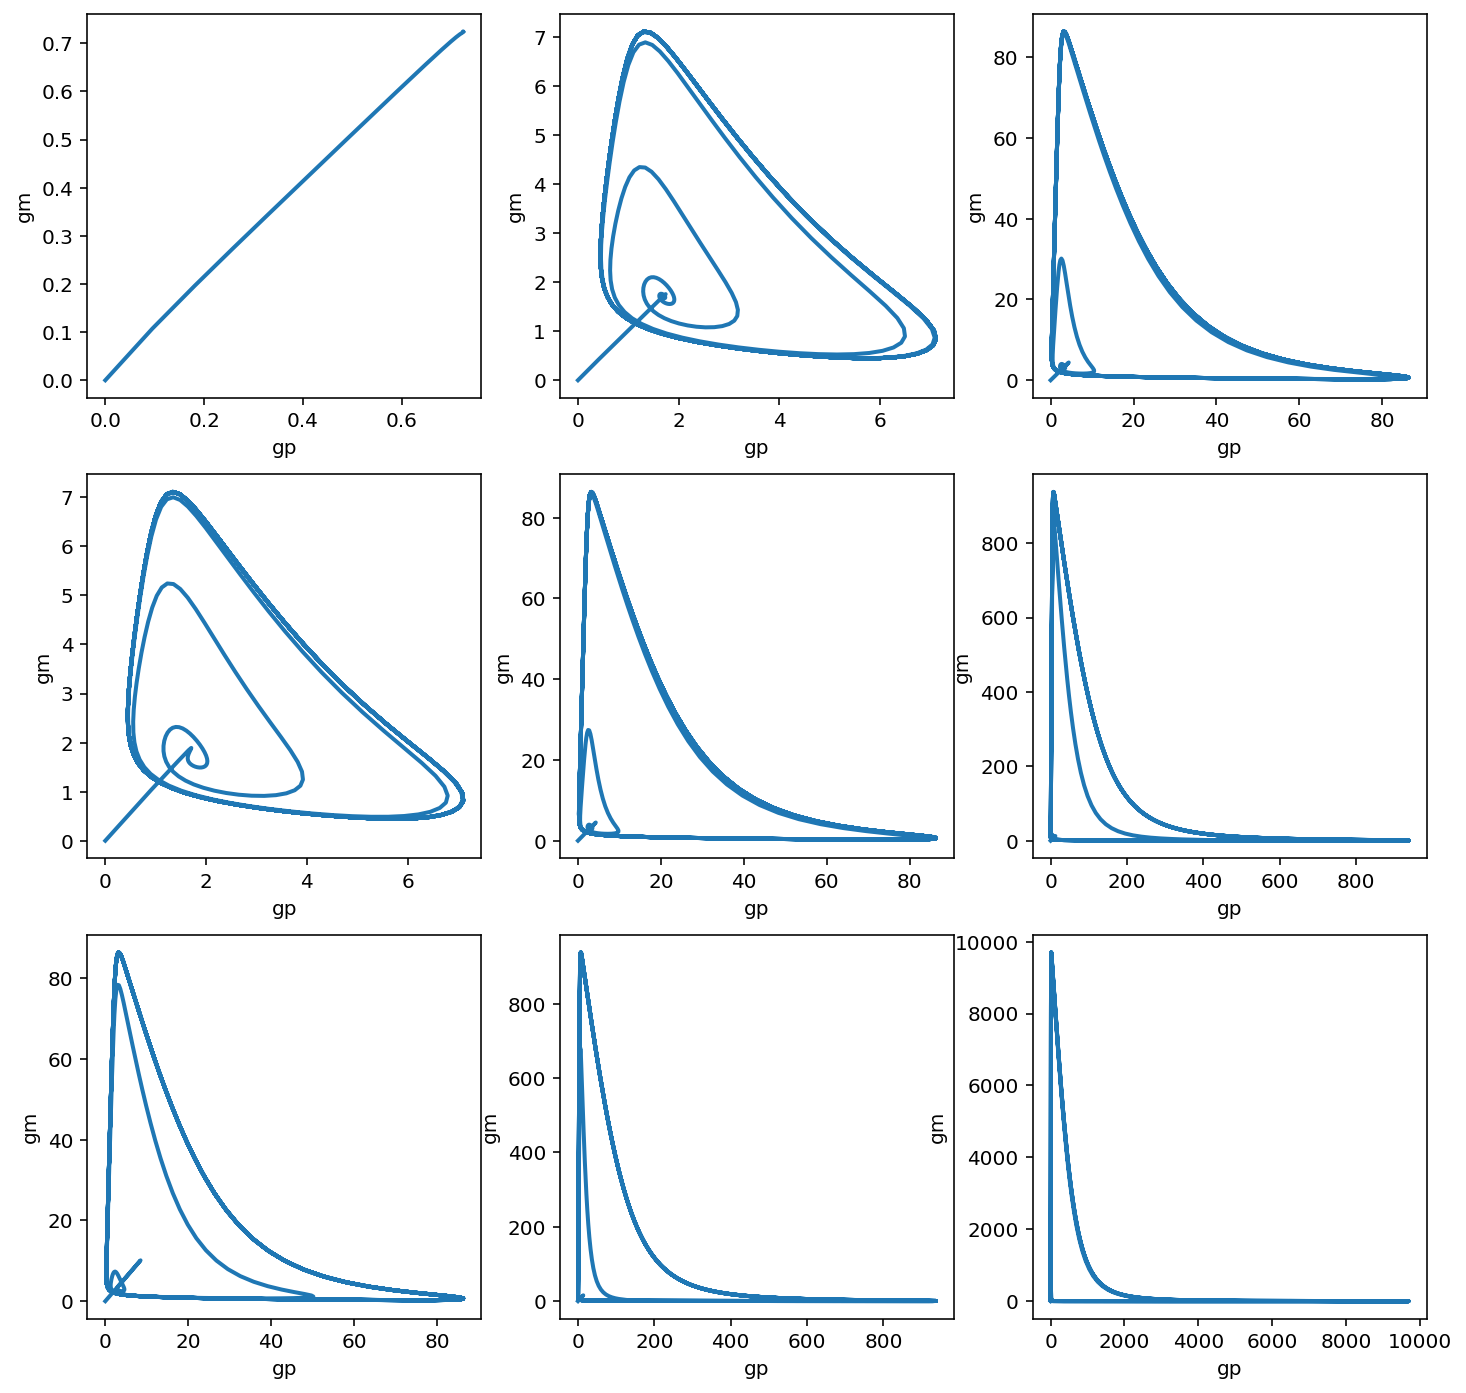

In [99]:
plb.figure(figsize=(12,12))

for i in range(9):
    plb.subplot(3,3,i+1)
    HillRepressilator.plot_phase_diagram(repls, repls3x1[i], repls3x3[i],
                                         "gm", "gp")

## Question 1b:

 Construct a Petri net representation of the system for case (i) with mRNA (i.e. corre-sponding to Eq. 1)
### (ii) without mRNA (i.e. corresponding to Eq.2)

In [11]:
# Considering the case without mRNA 
# Creating an empty PetriNet

nX = PetriNet("repsX")

# creating places with arbitrary tokens

nX.add_place(Place('x1', [1]))
nX.add_place(Place('x2', [1]))
nX.add_place(Place('x3', [1]))

# create reactions

# rxns involving the proteins
nX.add_transition(Transition('t4', Expression('x1_deg') ))
nX.add_transition(Transition('t5', Expression('x2_deg') ))
nX.add_transition(Transition('t6', Expression('x3_deg') ))

# rxns involving mRNAs
nX.add_transition(Transition('t1', Expression('x1_prod') ))
nX.add_transition(Transition('t2', Expression('x2_prod') ))
nX.add_transition(Transition('t3', Expression('x3_prod') ))


# add arcs to link up transitions
nX.add_output('x1', 't1', Value(1))
nX.add_input('x1', 't4', Value(1))

nX.add_output('x2', 't2', Value(1))
nX.add_input('x2', 't5', Value(1))

nX.add_output('x3', 't3', Value(1))
nX.add_input('x3', 't6', Value(1))

nX.add_input('x1', 't2', Value(1))
nX.add_input('x2', 't3', Value(1))
nX.add_input('x3', 't1', Value(1))

Graph(['node_7', 'node_3', 'node_2', 'node_6', 'node_4', 'node_1', 'node_0', 'node_5', 'node_8'], [])

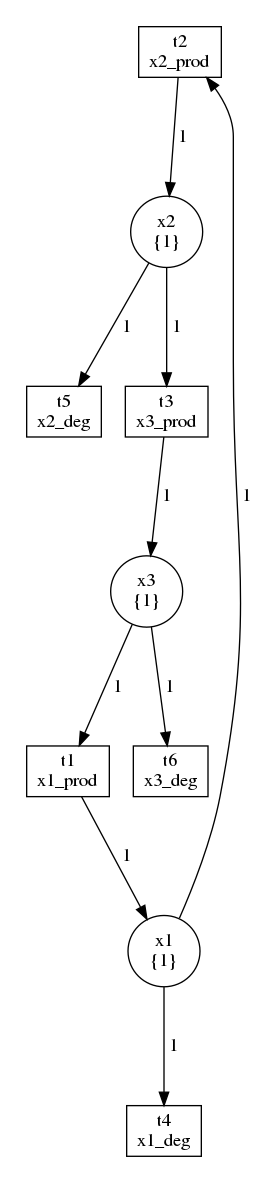

In [245]:
nX.draw("repsXSimple.png")

#display image
from IPython.display import Image
Image(filename='repsXSimple.png') 

In [80]:

# Including specie

# Creating an empty PetriNet

nX = PetriNet("repsX")

# creating places with arbitrary tokens

nX.add_place(Place('src',[1e8]))
nX.add_place(Place('x1', [1]))
nX.add_place(Place('x2', [1]))
nX.add_place(Place('x3', [1]))
nX.add_place(Place('sink', [0]))

# create reactions

# rxns involving the proteins
nX.add_transition(Transition('t4', Expression('x1_deg') ))
nX.add_transition(Transition('t5', Expression('x2_deg') ))
nX.add_transition(Transition('t6', Expression('x3_deg') ))

# rxns involving mRNAs
nX.add_transition(Transition('t1', Expression('x1_prod') ))
nX.add_transition(Transition('t2', Expression('x2_prod') ))
nX.add_transition(Transition('t3', Expression('x3_prod') ))


# add arcs to link up transitions


nX.add_output('x1', 't1', Value(1))
nX.add_input('x1', 't4', Value(1))

nX.add_output('x2', 't2', Value(1))
nX.add_input('x2', 't5', Value(1))

nX.add_output('x3', 't3', Value(1))
nX.add_input('x3', 't6', Value(1))

nX.add_input('x1', 't2', Value(1))
nX.add_input('x2', 't3', Value(1))
nX.add_input('x3', 't1', Value(1))

nX.add_output('sink', 't5', Value(1))
nX.add_output('sink', 't6', Value(1))
nX.add_output('sink', 't4', Value(1))
nX.add_input('src', 't3', Value(1))
nX.add_input('src', 't2', Value(1))
nX.add_input('src', 't1', Value(1))

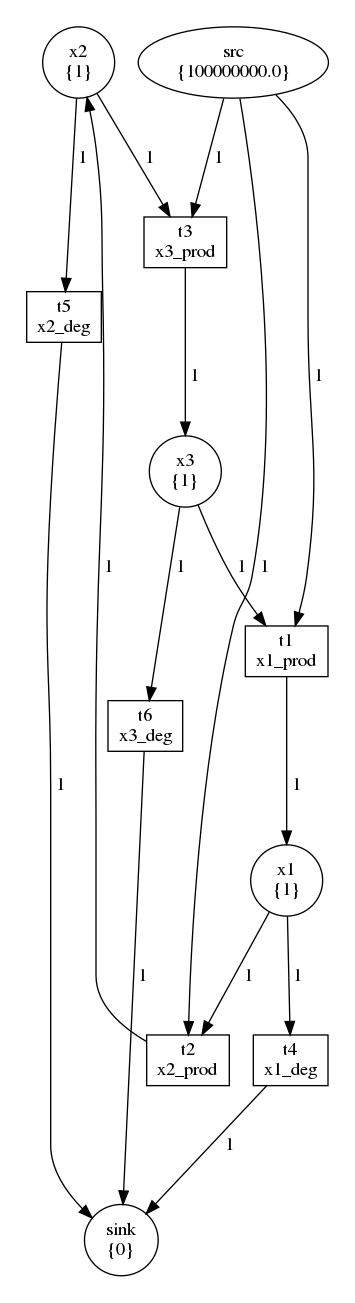

In [81]:
nX.draw("repsX.png")

#display image
from IPython.display import Image
Image(filename='repsX.png') 

## Question 2b:

### Solve the ODEs for case (i) numerically with parameters: k= 1 and dp=gp.¶


In [103]:
# <codecell>
class HillRepressilatorX:
    def __init__(self, gamma_p, del_p, n, k, y0):
        """
        Initiate a HillRepressilator (i.e., a Repressilator where the
        protein-DNA interaction is subsumed in a simple Hill function).
        Instance parameters are initialized based on the input parameters
        Also store the bare parameters (K_m, K_p, T, K_b) so that you can
        convert from scaled times and concentrations back to bare times
        and concentrations if desired.
        """
        
        self.gamma_p = 10**gamma_p
        self.del_p=10**del_p
        self.n = n
        self.k = k
        self.y0_3 = y0



    @staticmethod
    def dydt(y, t, log_gp, log_dp, n, k):
        """Define the right-hand-side of the Repressilator equations
        for use with scipy.integrate.odeint.  Since this needs to be called
        as if it were a standalone function, and not an instance method
        (which would implicitly assume the first argument is the instance
        self), we declare this as a staticmethod so that self is not passed
        as an implicit argument.  Alternatively, one could define dydt
        outside the HillRepressilator class, but this is cleaner."""
        
        """
    Returns 3-array of (dx_1/dt, dx_2/dt, dx_3/dt)
    """

        gamma_p = 10**log_gp
        del_p=10**log_dp
        
        x_1, x_2, x_3 = y
    
        return np.array(
            [
                gamma_p/(1+(k*(x_3**n))) - del_p*x_1,
                gamma_p/(1+(k*(x_1**n))) - del_p*x_2,
                gamma_p/(1+(k*(x_2**n))) - del_p*x_3
            ]
        )
        
        
    def run(self, y0, T, nT, params):
        """
        run(self, )
        Run the Repressilator for the specified amount of time T, returning
        output for a specified array of times.  Store the trajectory returned
        by odeint in the instance variable self.traj, concatenating the result
        to the existing self.traj if a previous trajectory had been created.
        """
        self.args = params
        self.time = np.linspace(0, T, nT)
        self.x = scipy.integrate.odeint(self.dydt, self.y0_3, self.time, self.args)
        x1, x2, x3 = self.x.transpose()
        self.traj = self.x.transpose()
        
        return [self.time, self.traj]
        
        
    def find_steady_state(self,alpha=None, n=None, alpha0=None):
        """Return the steady-state concentration of mRNAs and proteins
        (i.e., an array of length 6) for the specified parameters
        alpha, n, alpha0.  Use scipy.optimize.fsolve."""
        pass
    

    def in_steady_state(self):
        """Return True or False indicating whether the current state of
        the system is in the steady-state.  Do this by evaluating the
        instantaneous time derivative of the equations of motion and
        checking whether the vector norm of the instantaneous velocity
        is sufficiently small (e.g., smaller than 1.0e-3)."""
        pass

    def rescale_trajectory(self):
        """Return a scaled trajectory from the data contained in the
        self.traj variable.  This undoes the scaling transformation into
        natural units, producing a 6-component trajectory
        containing raw molecular concentrations."""
        pass

    def plot(self, time, soln):
        """Plot the trajectory of the Repressilator, optionally showing
        either the protein concentrations or the mRNA concentrations,
        in either dimensionless or rescaled units."""
        
        number = 6
        cmap = plt.get_cmap('gnuplot')
        colors = [cmap(i) for i in np.linspace(0, 1, number)]
    
        
        x1, x2, x3 = soln
   
        plt.plot(time, x1, LineWidth=2, color=colors[0], label="x1")
        plt.plot(time, x2, LineWidth=2, color=colors[2], label="x2")
        plt.plot(time, x3, LineWidth=2, color=colors[4], label="x3")
        plt.legend(loc='best')
        plt.show()
            
  
        
    @staticmethod
    def f(beta, X):
        pass

    def find_unstable_beta(self, alpha):
        pass

    def plot_phase_boundary(self, tsolve, soln):
        pass

    def compute_phase_diagram(self):
        pass

    def plot_phase_diagram(self, var1, var2, varName1, varName2):
        # Solve for species concentrations    
        
        self.var1 = var1
        self.var2 = var2
        
        #p.circle(x_fp, x_fp, color="black", size=12)
        plt.plot(self.var1, self.var2, lineWidth=2)
        plt.ylabel(varName1)
        plt.xlabel(varName2)

        return plt

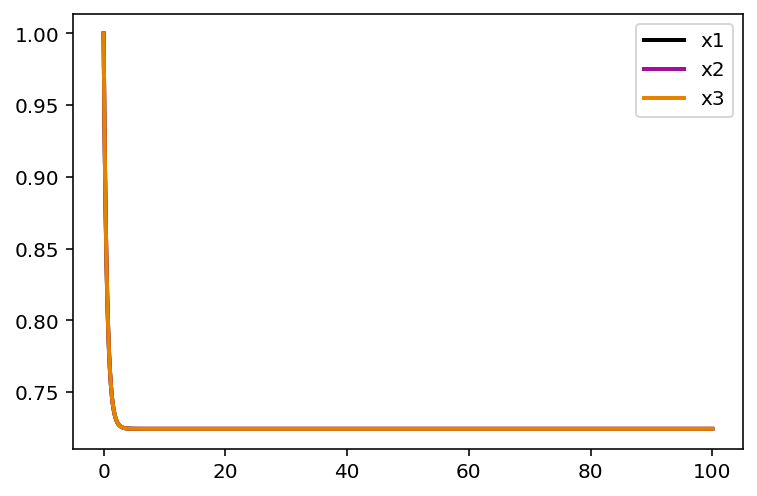

In [108]:
n=3.
k=1

# protein production and decay rate
log_dp=0
log_gp=0

y0=[1.0,1.0,1.0]

replsX = HillRepressilatorX(log_gp, log_dp, n, k, y0)

params = (log_gp, log_dp, n, k)

# [time, ysol]
[tsolve, soln] = HillRepressilatorX.run(replsX, y0, 100, 10000, params)
HillRepressilatorX.plot(replsX, tsolve, soln)

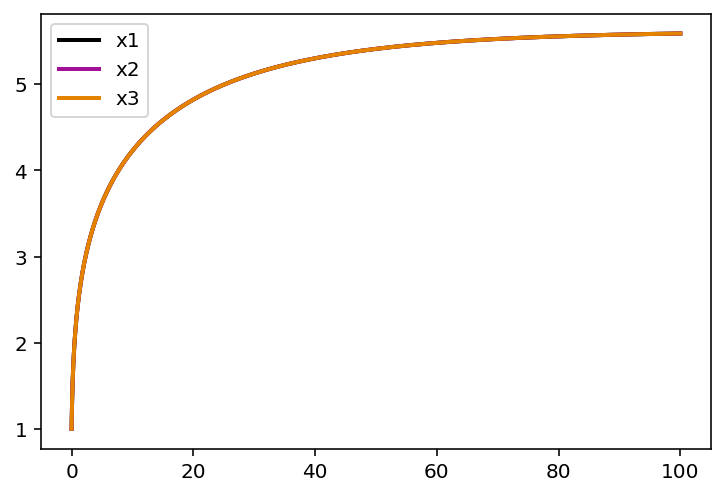

In [109]:
n=3.
k=1

# protein production and decay rate
log_dp=-2
log_gp=1

y0=[1.0,1.0,1.0]

replsX = HillRepressilatorX(log_gp, log_dp, n, k, y0)

params = (log_gp, log_dp, n, k)

# [time, ysol]
[tsolve, soln] = HillRepressilatorX.run(replsX, y0, 100, 10000, params)
HillRepressilatorX.plot(replsX, tsolve, soln)

## Question 3:

### Plot phase portraits showing the region in which the system displays oscillations, with values of gp on the x-axis plotted against values of gm on the y-axis, for Hill coefficients n= [1,2,3]

<module 'matplotlib.pyplot' from '/home/dcajuzie/.virtualenvs/dl4cv/lib/python3.6/site-packages/matplotlib/pyplot.py'>

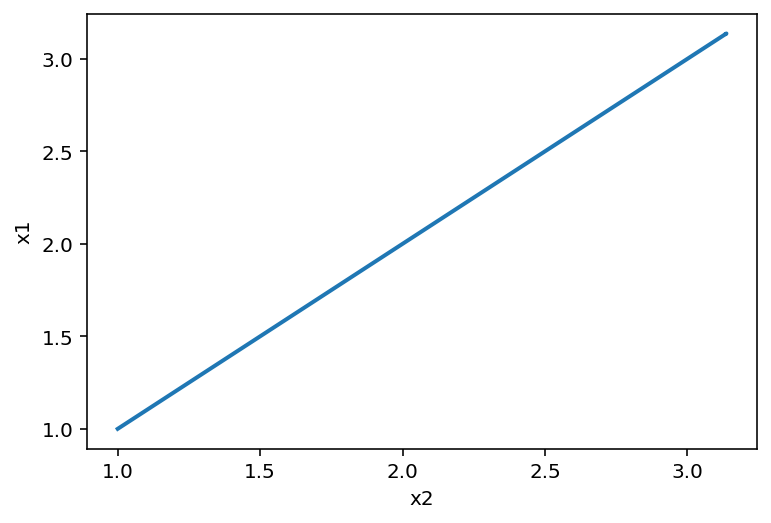

In [110]:
# Phase portrait

replsX = HillRepressilatorX(log_gp, log_dp, n, k, y0)
params = (log_gm, log_gp, n, k)
[tsolve, soln] = HillRepressilatorX.run(replsX, y0, 100, 10000, params)
x1, x2, x3 = soln

HillRepressilatorX.plot_phase_diagram(repls, x1, x2, "x1", "x2")

## Case n = 1:

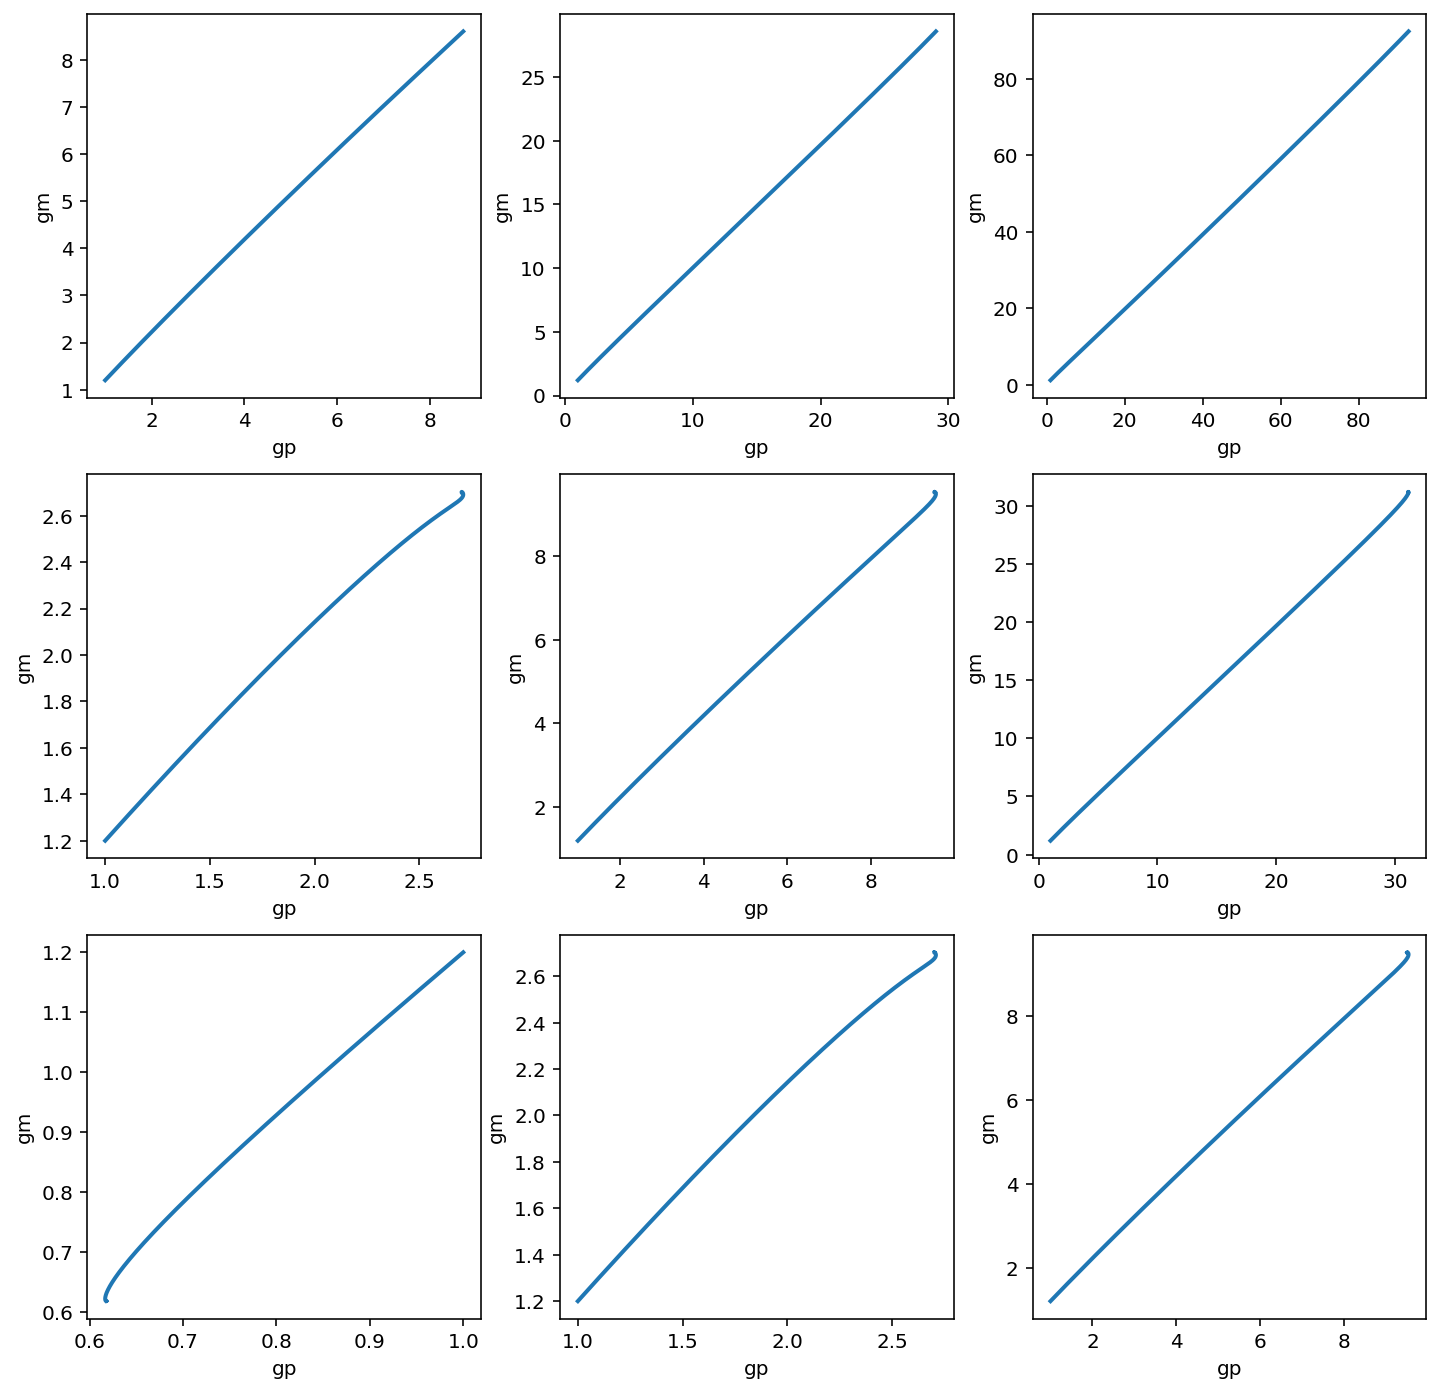

In [111]:
k=1
d_m=1.
y0=[1,1.1,1.2]

# protein production and decay rate
# ranging from -3 to 0
log_dp=1.
log_gp=1.


replsX1x1 = []
replsX1x2 = []
replsX1x3 = []
replsX2x1 = []
replsX2x2 = []
replsX2x3 = []
replsX3x1 = []
replsX3x2 = []
replsX3x3 = []

n = 1
for log_gp in range(-2,1):
    for log_gm in range(0,3):
        replsX = HillRepressilatorX(log_gp, log_dp, n, k, y0)
        params = (log_gm, log_gp, n, k)
        [tsolve, soln] = HillRepressilatorX.run(replsX, y0, 100, 10000, params)
        x1, x2, x3 = soln
        replsX1x1.append(x1)
        replsX1x3.append(x3)

n = 2
for log_gp in range(0,3):
    for log_gm in range(1,4):
        replsX = HillRepressilatorX(log_gp, log_dp, n, k, y0)
        params = (log_gm, log_gp, n, k)
        [tsolve, soln] = HillRepressilatorX.run(replsX, y0, 100, 10000, params)
        x1, x2, x3 = soln
        replsX2x1.append(x1)
        replsX2x3.append(x3)
        
n = 3
for log_gp in range(0,3):
    for log_gm in range(1,4):
        replsX = HillRepressilatorX(log_gp, log_dp, n, k, y0)
        params = (log_gm, log_gp, n, k)
        [tsolve, soln] = HillRepressilatorX.run(replsX, y0, 100, 10000, params)
        x1, x2, x3 = soln
        replsX3x1.append(x1)
        replsX3x3.append(x3)
        
import matplotlib.pylab as plb
        
        
plb.figure(figsize=(12,12))

for i in range(9):
    plb.subplot(3,3,i+1)
    HillRepressilatorX.plot_phase_diagram(replsX, replsX1x1[i], replsX1x3[i],
                                         "gm", "gp")       


## Case n = 2:

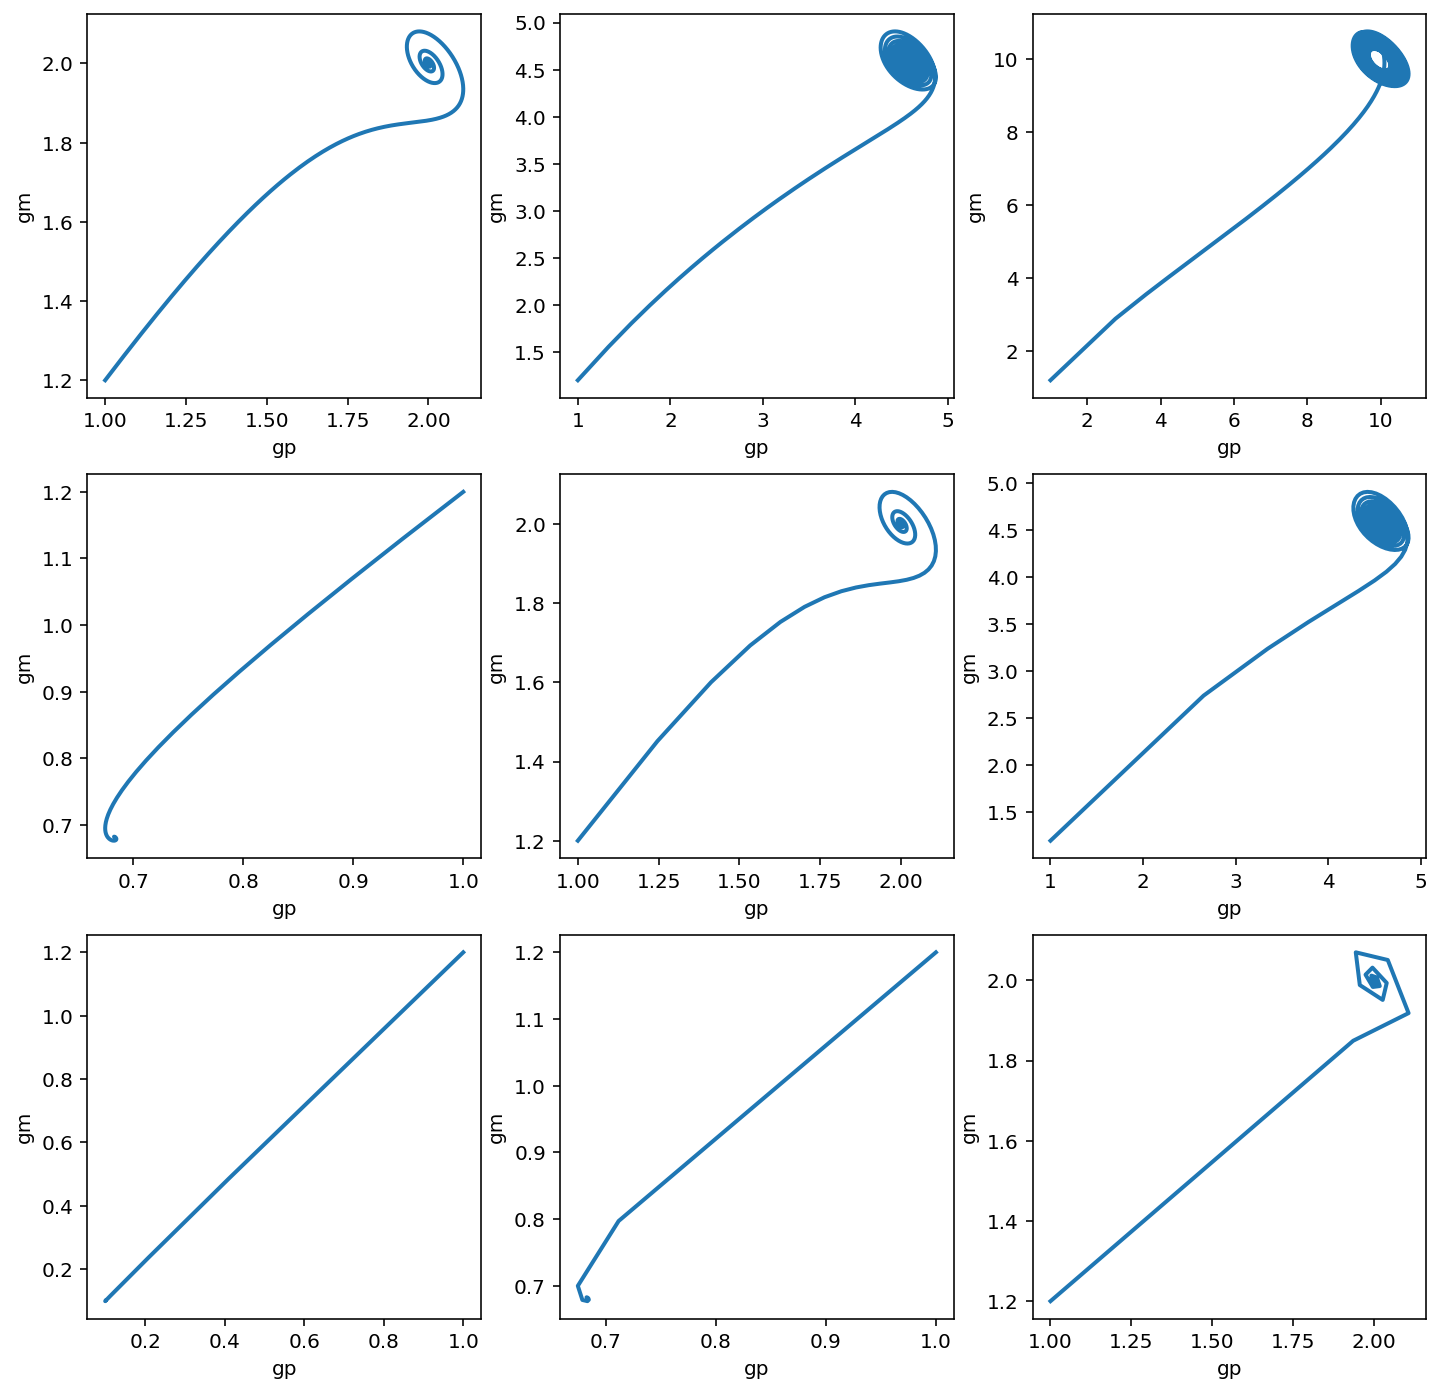

In [97]:
plb.figure(figsize=(12,12))

for i in range(9):
    plb.subplot(3,3,i+1)
    HillRepressilatorX.plot_phase_diagram(replsX, replsX2x1[i], replsX2x3[i],
                                         "gm", "gp")

## Case n = 3:

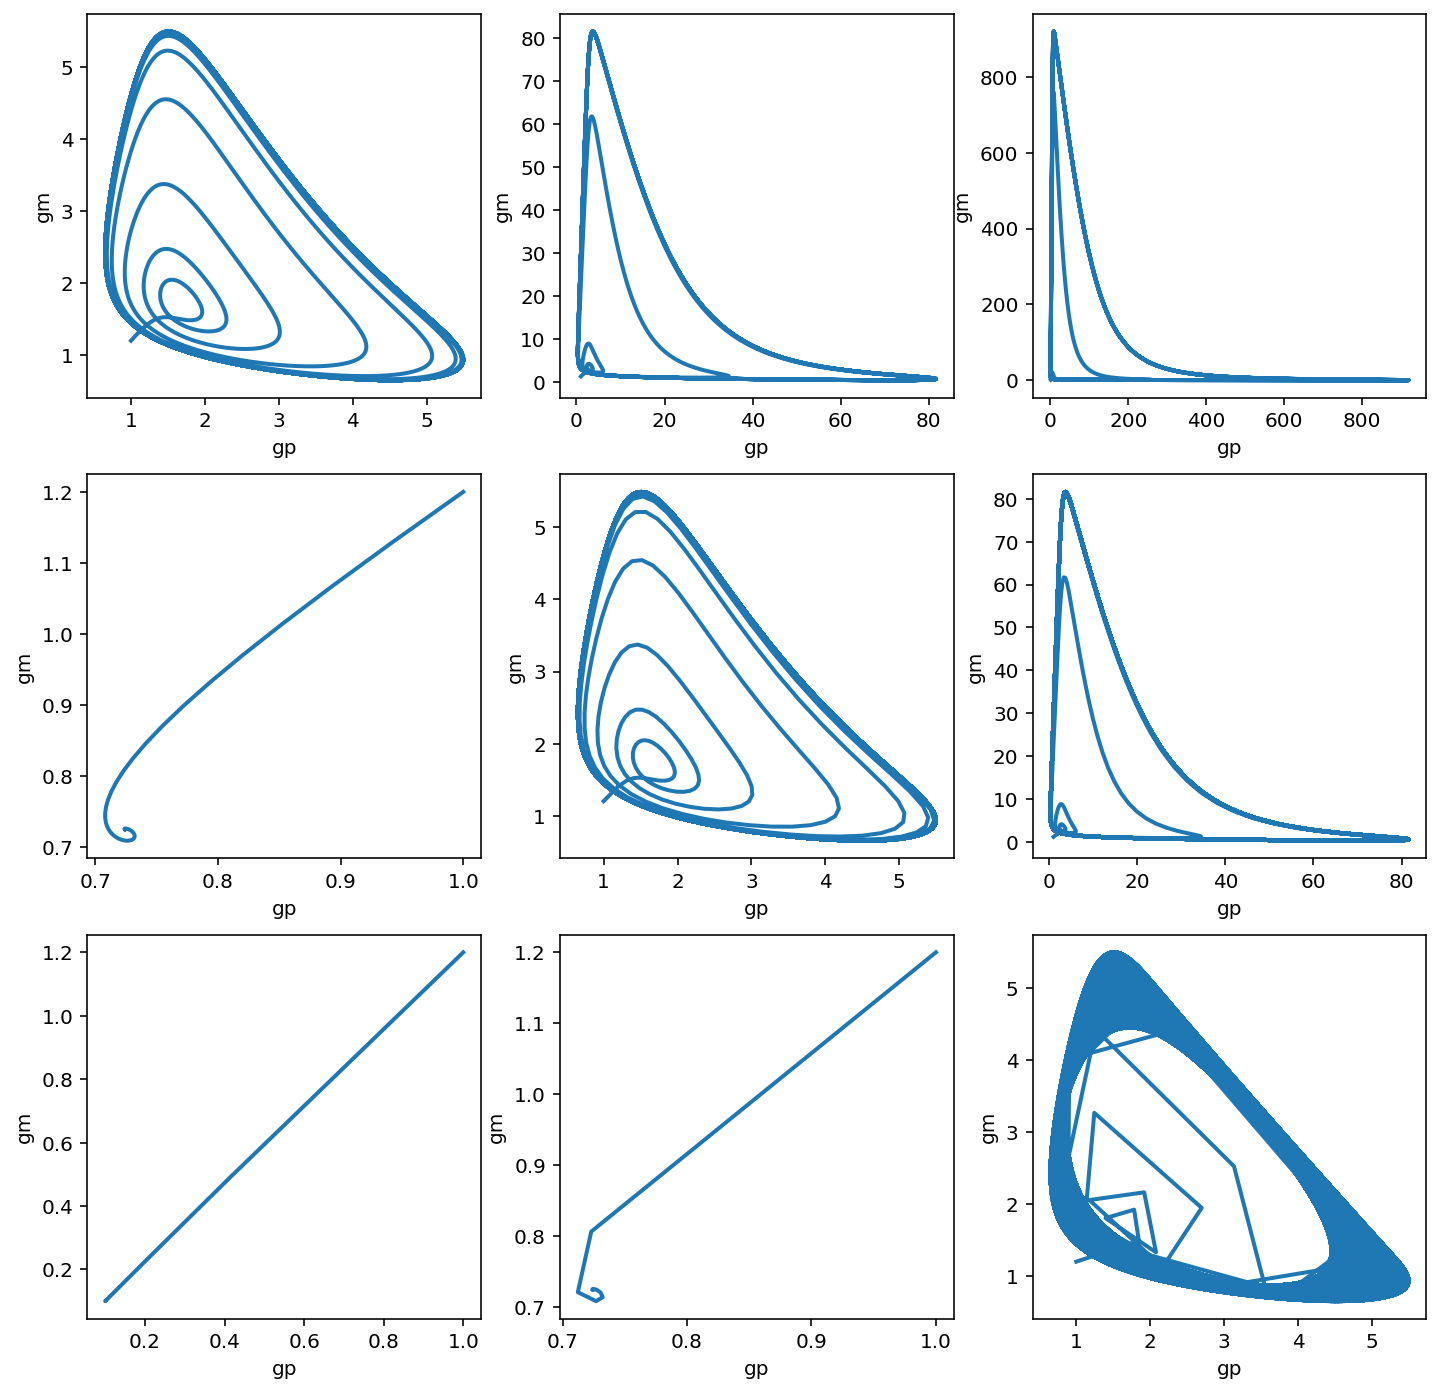

In [96]:
plb.figure(figsize=(12,12))

for i in range(9):
    plb.subplot(3,3,i+1)
    HillRepressilator.plot_phase_diagram(replsX, replsX3x1[i], replsX3x3[i],
                                         "gm", "gp")